<a href="https://colab.research.google.com/github/JaquelineEspinoza/EDP2/blob/main/Ecuaci%C3%B3n%20del%20Calor.%20M%C3%A9todo%20impl%C3%ADcito%20de%20Crank-Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parámetros: dx = 0.1000, dt = 0.001000, r = 0.1000

EJERCICIO 1: TABLA DE SOLUCIONES NUMÉRICAS
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|      t/x |     0.10 |     0.20 |     0.30 |     0.40 |     0.50 |     0.60 |     0.70 |     0.80 |     0.90 |
+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+
| 0.000000 | 0.352364 | 0.632017 | 0.832001 | 0.952000 | 0.992000 | 0.952000 | 0.832001 | 0.632017 | 0.352364 |
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| 0.001000 | 0.345394 | 0.624094 | 0.824006 | 0.944000 | 0.984000 | 0.944000 | 0.824006 | 0.624094 | 0.345394 |
+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| 0.002000 | 0.338976 | 0.616277 | 0.816022 | 0.936002 | 0.976000 | 0.936002 | 0.816022 | 0.616277 | 0.338976 |
+--------

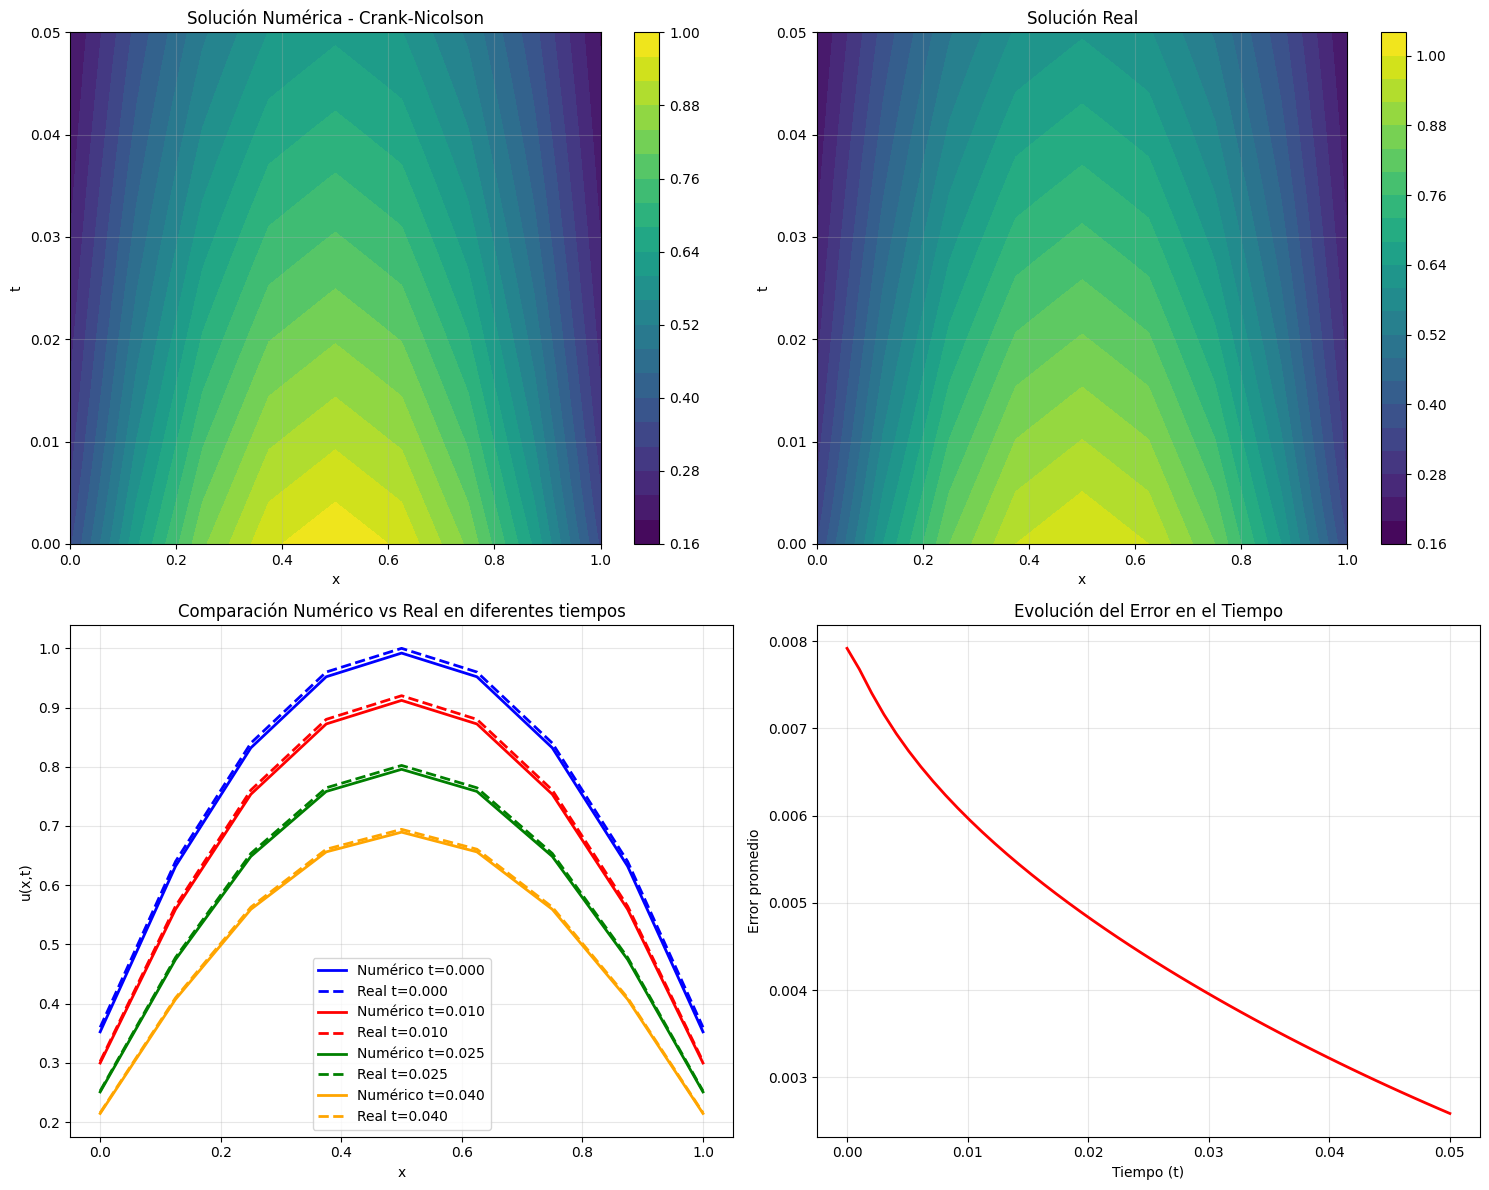

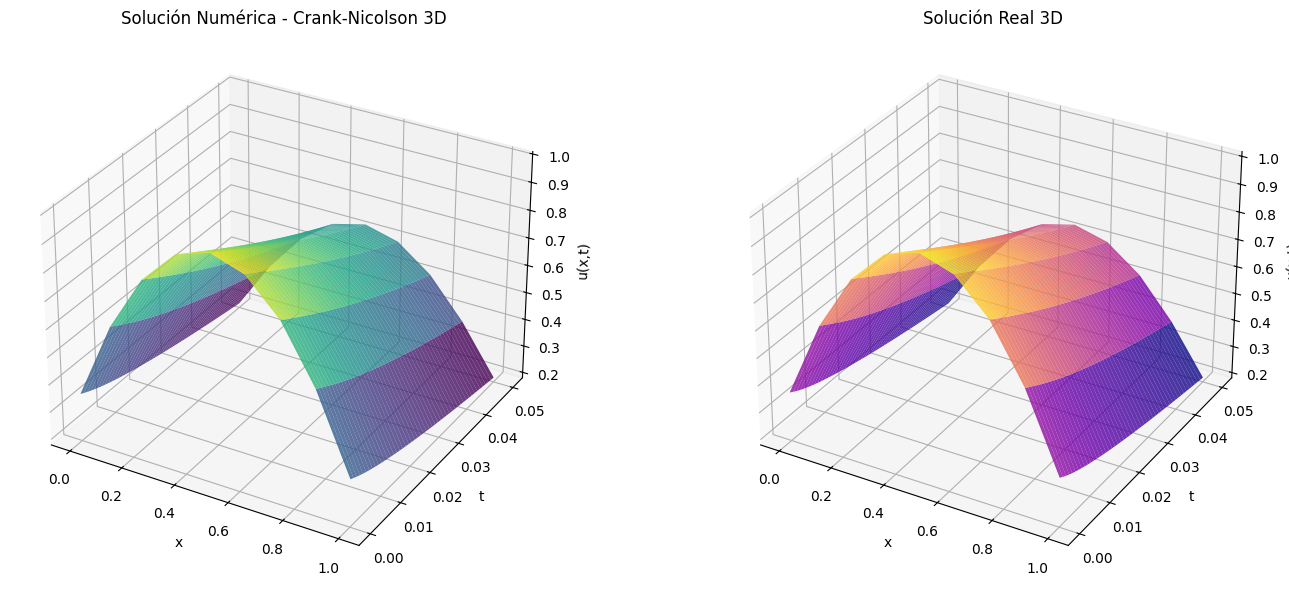


RESUMEN EJECUCIÓN
Dominio espacial: [0, 1.0]
Tiempo final: 0.05
Nodos espaciales: 9 (dx = 0.1000)
Pasos temporales: 50 (dt = 0.001000)
Parámetro r = dt/dx² = 0.1000
Error máximo: 0.008004
Error promedio: 0.004624


In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tabulate import tabulate

# Parámetros del problema
L = 1.0  # Longitud del dominio espacial
T = 0.05  # Tiempo final
nx = 9   # Número de nodos internos en x
nt = 50  # Número de pasos en tiempo

# Discretización
dx = L / (nx + 1)
dt = T / nt
r = dt / (dx**2)

print(f"Parámetros: dx = {dx:.4f}, dt = {dt:.6f}, r = {r:.4f}")

def f(x):
    """Condición inicial"""
    return 1 - 4*(x - 0.5)**2

def tridiagonal(n, a, b):
    """Crea matriz tridiagonal n x n con a en diagonal y b en sub/super diagonales"""
    return sp.Matrix([
        [a if i == j else b if abs(i-j) == 1 else 0 for j in range(n)]
        for i in range(n)
    ])

# Matrices A y B para Crank-Nicolson
A = tridiagonal(nx, 2 + 2*r, -r)
B = tridiagonal(nx, 2 - 2*r, r)  # CORRECCIÓN: debería ser +r, no -r

# Vector inicial
x_nodes = [i*dx for i in range(1, nx+1)]
b = sp.Matrix([f(x) for x in x_nodes])

def crank_nicolson(A, B, b, j):
    """Implementación del método de Crank-Nicolson"""
    b_current = b.copy()
    solutions = []

    for i in range(j):
        # Resolver A * u^{n+1} = B * u^n
        b_rhs = B * b_current
        u_next = A.LUsolve(b_rhs)
        solutions.append(u_next.T)
        b_current = u_next

    return sp.Matrix(solutions)

# EJERCICIO 1: Tabla similar a la tabla 2.6
print("\n" + "="*60)
print("EJERCICIO 1: TABLA DE SOLUCIONES NUMÉRICAS")
print("="*60)

# Calcular soluciones
U = crank_nicolson(A, B, b, nt)

# Crear tabla para los primeros 5 pasos de tiempo
headers = ["t/x"] + [f"{x:.2f}" for x in x_nodes]
table_data = []

for i in range(min(6, nt)):  # Primeros 6 pasos de tiempo
    t_val = i * dt
    row = [f"{t_val:.4f}"] + [f"{float(U[i,j]):.6f}" for j in range(nx)]
    table_data.append(row)

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".6f"))

# EJERCICIO 2: Comparación con solución real
print("\n" + "="*60)
print("EJERCICIO 2: COMPARACIÓN CON SOLUCIÓN REAL")
print("="*60)

def solucion_real(x, t, n_terms=50):
    """Solución analítica de la ecuación de calor con condiciones de Dirichlet"""
    u = 0
    for n in range(1, n_terms + 1):
        lambda_n = n * np.pi / L
        # Coeficiente de Fourier
        integral = 0
        for k in range(100):  # Integración numérica
            xi = k * L / 100
            integral += f(xi) * np.sin(lambda_n * xi) * (L/100)

        cn = (2/L) * integral
        u += cn * np.sin(lambda_n * x) * np.exp(-lambda_n**2 * t)
    return u

# Calcular solución real en los mismos puntos
U_real_np = np.zeros((nt, nx))
for i in range(nt):
    t_val = i * dt
    for j in range(nx):
        U_real_np[i, j] = solucion_real(x_nodes[j], t_val)

# Convertir solución numérica a numpy
U_np = np.array(U.tolist(), dtype=float)

# Calcular error
error = np.abs(U_np - U_real_np)
error_max = np.max(error)
error_promedio = np.mean(error)

print(f"Error máximo: {error_max:.6f}")
print(f"Error promedio: {error_promedio:.6f}")

# Tabla comparativa para algunos puntos
print("\nComparación en algunos puntos seleccionados:")
comparison_headers = ["(x,t)", "Numérico", "Real", "Error"]
comparison_data = []

# Puntos para comparar
points_to_compare = [(0, 0), (2, 10), (4, 25), (6, 40)]  # (índice_x, índice_t)

for idx_x, idx_t in points_to_compare:
    if idx_t < nt and idx_x < nx:
        x_val = x_nodes[idx_x]
        t_val = idx_t * dt
        num_val = U_np[idx_t, idx_x]
        real_val = U_real_np[idx_t, idx_x]
        err_val = abs(num_val - real_val)

        comparison_data.append([
            f"({x_val:.2f}, {t_val:.4f})",
            f"{num_val:.6f}",
            f"{real_val:.6f}",
            f"{err_val:.6f}"
        ])

print(tabulate(comparison_data, headers=comparison_headers, tablefmt="grid"))

# Gráficas comparativas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mapa de calor de la solución numérica
x_plot = np.linspace(0, L, nx)
t_plot = np.linspace(0, T, nt)
X, T_mesh = np.meshgrid(x_plot, t_plot)

ax1 = axes[0, 0]
contour1 = ax1.contourf(X, T_mesh, U_np, levels=20, cmap='viridis')
plt.colorbar(contour1, ax=ax1)
ax1.set_title('Solución Numérica - Crank-Nicolson')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.grid(True, alpha=0.3)

# 2. Mapa de calor de la solución real
ax2 = axes[0, 1]
contour2 = ax2.contourf(X, T_mesh, U_real_np, levels=20, cmap='viridis')
plt.colorbar(contour2, ax=ax2)
ax2.set_title('Solución Real')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.grid(True, alpha=0.3)

# 3. Comparación en diferentes tiempos
ax3 = axes[1, 0]
times_to_plot = [0, 10, 25, 40]  # Índices de tiempo
colors = ['blue', 'red', 'green', 'orange']
labels = ['t=0.000', 't=0.010', 't=0.025', 't=0.040']

for i, t_idx in enumerate(times_to_plot):
    if t_idx < nt:
        ax3.plot(x_plot, U_np[t_idx, :],
                color=colors[i], linestyle='-', linewidth=2, label=f'Numérico {labels[i]}')
        ax3.plot(x_plot, U_real_np[t_idx, :],
                color=colors[i], linestyle='--', linewidth=2, label=f'Real {labels[i]}')

ax3.set_xlabel('x')
ax3.set_ylabel('u(x,t)')
ax3.set_title('Comparación Numérico vs Real en diferentes tiempos')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Error en el tiempo
ax4 = axes[1, 1]
error_por_tiempo = np.mean(error, axis=1)
ax4.plot(t_plot, error_por_tiempo, 'r-', linewidth=2)
ax4.set_xlabel('Tiempo (t)')
ax4.set_ylabel('Error promedio')
ax4.set_title('Evolución del Error en el Tiempo')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfica 3D
fig = plt.figure(figsize=(15, 6))

# Solución numérica 3D
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, T_mesh, U_np, cmap='viridis', alpha=0.8)
ax1.set_title('Solución Numérica - Crank-Nicolson 3D')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u(x,t)')

# Solución real 3D
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, T_mesh, U_real_np, cmap='plasma', alpha=0.8)
ax2.set_title('Solución Real 3D')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('u(x,t)')

plt.tight_layout()
plt.show()

# Resumen final
print("\n" + "="*60)
print("RESUMEN EJECUCIÓN")
print("="*60)
print(f"Dominio espacial: [0, {L}]")
print(f"Tiempo final: {T}")
print(f"Nodos espaciales: {nx} (dx = {dx:.4f})")
print(f"Pasos temporales: {nt} (dt = {dt:.6f})")
print(f"Parámetro r = dt/dx² = {r:.4f}")
print(f"Error máximo: {error_max:.6f}")
print(f"Error promedio: {error_promedio:.6f}")